#K - Times Markov Sampling for Letter dataset

In [2]:
# Import all dependencies
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale



---


Connecting  to the  Google drive for easy import and export of data


---


In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



---


Reading the csv file made for the dataset - And initializing the dataframe with it


---



In [27]:
letters = pd.read_csv("/content/letter-recognition.csv")
letters.columns = ['letter', 'xbox', 'ybox', 'width', 'height', 'onpix', 'xbar','ybar', 'x2bar', 'y2bar', 'xybar', 'x2ybar', 'xy2bar', 'xedge','xedgey', 'yedge', 'yedgex']

print("Letter dataset in csv format -----------")
print(letters)

Letter dataset in csv format -----------
      letter  xbox  ybox  width  height  ...  xy2bar  xedge  xedgey  yedge  yedgex
0          I     5    12      3       7  ...       9      2       8      4      10
1          D     4    11      6       8  ...       7      3       7      3       9
2          N     7    11      6       6  ...      10      6      10      2       8
3          G     2     1      3       1  ...       9      1       7      5      10
4          S     4    11      5       8  ...       6      0       8      9       7
...      ...   ...   ...    ...     ...  ...     ...    ...     ...    ...     ...
19994      D     2     2      3       3  ...       4      2       8      3       7
19995      C     7    10      8       8  ...      13      2       9      3       7
19996      T     6     9      6       7  ...       5      2      12      2       4
19997      S     2     3      4       2  ...       8      1       9      5       8
19998      A     4     9      6       6  ...  

## Starting with the algorithm : 


---


### K - TIMES MARKOV SAMPLING FOR SVMC


---


**Step 1** : Draw randomly N samples Siid := {zj}N
j=1 from ST . Train Siid by SVMC and obtain a preliminary
learning model f0. Let i = 0.


---



In [28]:
markov= pd.DataFrame(columns = letters.columns)
uniqChar=list(np.sort(letters['letter'].unique()))
classCNT=len(uniqChar)
limit=100
m=classCNT*limit
charNo={}
c=0
for i in uniqChar:
    charNo[i]=c
    c+=1
mAZ={i:0 for i in uniqChar}

# Choosing parameters
k=5
q=1.2
acc=0



---


Train a linear Model on N[here 2000] size train set


---



In [29]:
X = letters.drop("letter", axis = 1)
y = letters['letter']

X_scaled = scale(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.9, random_state = 101)
model_linear = SVC(kernel='linear')
model_linear.fit(X_train, y_train)

# predict
y_pred = model_linear.predict(X_test)

print("Displaying the predicted value ----------------")
print(y_pred)

Displaying the predicted value ----------------
['X' 'M' 'E' ... 'M' 'B' 'J']



---


**Step 2 :** Let N+ = 0, N− = 0, t = 1.


---


In [30]:
# Chosing a random sample as first of markov chain
i=np.random.randint(letters.shape[0])
z0=letters.iloc[i]
y0=model_linear.predict(np.array([z0.drop('letter')]))[0]
if m%classCNT==0:
    mAZ[z0['letter']]+=1

d={}
for i,val in z0.items():
    print(i,val)
    d[i]=val
markov.append(d,ignore_index=True)

print()
print("The generated Markov Chain :")
print(markov)
print()

letter M
xbox 4
ybox 7
width 6
height 5
onpix 4
xbar 6
ybar 6
x2bar 7
y2bar 5
xybar 7
x2ybar 8
xy2bar 11
xedge 8
xedgey 5
yedge 2
yedgex 9

The generated Markov Chain :
Empty DataFrame
Columns: [letter, xbox, ybox, width, height, onpix, xbar, ybar, x2bar, y2bar, xybar, x2ybar, xy2bar, xedge, xedgey, yedge, yedgex]
Index: []



In [31]:
predProb=[]


---


# Step 3 To Step 7


---

**Step 3 :**  Draw randomly a sample zt from ST , called it the current sample. Let N+ = N+ + 1 if the label of zt is +1, or let N− = N− + 1 if the label of zt is −1.

**Step 4 :** Draw randomly another sample z∗ from ST , called it the candidate sample, and calculate the ratio α, α = e−( fi,z∗)/e−( fi,zt).

**Step 5 :** If α ≥ 1, yt y∗ = 1 accept z∗ with probability α1 = e−y∗ fi /e−yt fi . If α = 1 and yt y∗ = −1 or α < 1, accept z∗ with probability α. If there are n2 candidate samples can not be accepted continually, then set α2 = qα and accept z∗ with probability α2. If z∗ is not accepted, go to Step 4, else let zt+1 = z∗, N+ = N+ + 1 if the label of zt+1 is +1 and N+ < N/2, or let zt+1 = z∗, N− = N−+1 if the label of zt+1 is −1 and N− < N/2 (if the value α (or α1, α2) is bigger than 1, accept the candidate sample z∗ with probability 1).

**Step 6 :** If N+ +N− < N, return to Step 4, else we obtain N Markov chain samples SMar. Let i = i + 1. Train SMar by SVMC and obtain a learning model fi .


**Step 7 :** If i < k, go to Step 2, else output sign( fk ).

---






---


Utility Function for loop condition


---



In [32]:
def exist(dic,limit):
    for i,val in dic.items():
        if val<limit:
            return True
    return False            



---


Utility loss Function


---



In [33]:
def lossF(actual,pred):
    if actual==pred:
        return 1.0
    return np.exp(-2)



---


Utility Function for getting class index


---



In [34]:
def getNo(ch):
    return charNo[ch]



---


Utility function for training subsequent models


---



In [35]:
def train(data):
    
    X = data.drop("letter", axis = 1)
    y = data['letter']

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8, random_state = 101)
    model_linear = SVC(kernel='linear')
    model_linear.fit(X_train, y_train)

    return model_linear

In [36]:
lst=[]



---


Loop To run the markov chain generator k times

---



In [38]:
for km in range(2):
    # Reset parameters for next markov chain
    if km!=0:
        predProb=[]
        model_linear=train(markov)
        markov= pd.DataFrame(columns = letters.columns)
        mAZ={i:0 for i in uniqChar}
    lst=[]
    
    # Chosing a random sample as first of markov chain
    i=np.random.randint(letters.shape[0])
    z0=letters.iloc[i]
    y0=model_linear.predict(np.array([z0.drop('letter')]))[0]
    if m%classCNT==0:
        mAZ[z0['letter']]+=1
    print("Choosing random sample ...........")
    while exist(mAZ,limit):
        # choosing a random sample
        i=np.random.randint(letters.shape[0])
        while i in lst:
            i=np.random.randint(letters.shape[0])
        z1=letters.iloc[i]
        y1=model_linear.predict(np.array([z1.drop('letter')]))[0]
        n=lossF(z1['letter'],y1)
        d=lossF(z0['letter'],y0)
        p=n/d
        
        # Deciding of acceptance of chosen sample and its probability in markov chain
        if acc==k:
            acc=0
            p2=q*p
            p2=min(p2,1)
            predProb.append([z1['letter'],y1,p2])
            markov=markov.append(z1)
            z0=z1
            mAZ[z1['letter']]+=1
            acc+=1
            lst.append(i)
        elif p==1 and z0['letter']==z1['letter']:
            n=np.exp(-getNo(y1)*getNo(z1['letter']))
            d=np.exp(-getNo(y0)*getNo(z0['letter']))

            p1=n/d
            p1=min(p1,1)
            predProb.append([z1['letter'],y1,p1])
            markov=markov.append(z1)
            z0=z1
            mAZ[z1['letter']]+=1
            acc+=1
            lst.append(i)
        elif p<1:
            predProb.append([z1['letter'],y1,p])
            markov=markov.append(z1)
            z0=z1
            mAZ[z1['letter']]+=1
            acc+=1
            lst.append(i)
        elif p==1 and z0['letter']!=z1['letter']:
            predProb.append([z1['letter'],y1,p])
            markov=markov.append(z1)
            z0=z1
            mAZ[z1['letter']]+=1
            acc+=1
            lst.append(i)

print("The generated Markov Chain :")
print(markov)

print("The predicted Probabilities :")
print(predProb)

Choosing random sample ...........
Choosing random sample ...........
The generated Markov Chain :
      letter xbox ybox width height  ... xy2bar xedge xedgey yedge yedgex
12670      J    4    9     6      7  ...      8     3      7     4      6
2340       H    3    6     4      4  ...      8     3      8     0      8
17393      N    2    1     2      2  ...      7     4      8     1      7
3777       I    5    7     6      8  ...      7     4      8     9     10
14449      H    7   11    10      8  ...      7     4      9     4      9
...      ...  ...  ...   ...    ...  ...    ...   ...    ...   ...    ...
11979      L    4    6     5      4  ...      9     2      8     4     10
9389       C    5   10     6      8  ...     13     1      8     4      9
10620      R    4    8     6      6  ...      7     4      6     7      8
6048       R    4    9     5      7  ...      9     3      6     6      9
11143      W    4    5     6      5  ...      8     9      9     8      8

[5283 rows x


---


Save data from generated markov chain

---



In [39]:
markov.to_csv("/content/drive/MyDrive/DMI_Assign1/KmarkovSamplesLetters.csv")



---


Creating a new list for predicted probability and appending new column or field to save the probability in the markov chain generated 

---



In [40]:
prob=[]
for i in predProb:
    prob.append(i[2])

markov['probability']=prob

---


Save the Predicted Probability


---


In [41]:
markov.to_csv("/content/drive/MyDrive/DMI_Assign1/KmarkovSamplesLettersProbability.csv")



---

Removing the letters in list and makking the new letters list , then saving it in csv file in drive


---



In [42]:
for i in lst:
    letters=letters.drop([i])
letters.to_csv('/content/drive/MyDrive/DMI_Assign1/KmarkovLettersRemaining.csv')

# SVM

In [44]:
train = pd.read_csv("/content/drive/MyDrive/DMI_Assign1/KmarkovSamplesLetters.csv")
test = pd.read_csv("/content/drive/MyDrive/DMI_Assign1/KmarkovLettersRemaining.csv")

In [45]:
train = train.drop(train.columns[[0]], axis=1)
test = test.drop(test.columns[[0]], axis=1)
train.columns = ['letter', 'xbox', 'ybox', 'width', 'height', 'onpix', 'xbar','ybar', 'x2bar', 'y2bar', 'xybar', 'x2ybar', 'xy2bar', 'xedge','xedgey', 'yedge', 'yedgex']
test.columns = ['letter', 'xbox', 'ybox', 'width', 'height', 'onpix', 'xbar','ybar', 'x2bar', 'y2bar', 'xybar', 'x2ybar', 'xy2bar', 'xedge','xedgey', 'yedge', 'yedgex']

In [46]:
X_train = train.drop("letter", axis = 1)
y_train = train["letter"]

X_test = test.drop("letter", axis = 1)
y_test = test["letter"]

In [47]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import chi2_kernel

def hellinger(X1, X2):
    return np.sqrt(np.dot(X1,X2.T))

def intersection(X1,X2):

  result = np.zeros((X1.shape[0],X2.shape[0]))
  X2=X2.T

  for i in range(len(X1)):
    # iterate through columns of Y
    for j in range(len(X2[0])):
      # iterate through rows of Y
      val=float('+inf')
      for k in range(len(X2)):
          val = min(val,X1[i][k] * X2[k][j])

      result[i][j] = val

  return result


---


Accuracy for all the kernels - linear, rbf, chi-squared, hellinger, intersection



---


In [48]:
x_axis = ['linear', 'rbf', 'chi-squared', 'hellinger']
y_axis = []

# Linear Kernel

model_linear = SVC(kernel='linear')
model_linear.fit(X_train, y_train)

y_pred = model_linear.predict(X_test)
acc = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
y_axis.append(acc)
print("Accuracy for linear kernel:", acc, "\n")

# RBF Kernel

model_linear = SVC(kernel='rbf')
model_linear.fit(X_train, y_train)

y_pred = model_linear.predict(X_test)
acc = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
y_axis.append(acc)
print("Accuracy for rbf kernel:", acc, "\n")

# Chi-squared kernel

model_linear = SVC(kernel=chi2_kernel)
model_linear.fit(X_train, y_train)

y_pred = model_linear.predict(X_test)
acc = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
y_axis.append(acc)
print("Accuracy for Chi-Squared kernel:", acc, "\n")

# Hellinger kernel

model_linear = SVC(kernel=hellinger)
model_linear.fit(X_train, y_train)

y_pred = model_linear.predict(X_test)
acc = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
y_axis.append(acc)
print("Accuracy for Hellinger kernel:", acc, "\n")


Accuracy for linear kernel: 0.8130606142973634 

Accuracy for rbf kernel: 0.8396982875781462 

Accuracy for Chi-Squared kernel: 0.8791111715139984 

Accuracy for Hellinger kernel: 0.7321962489807012 



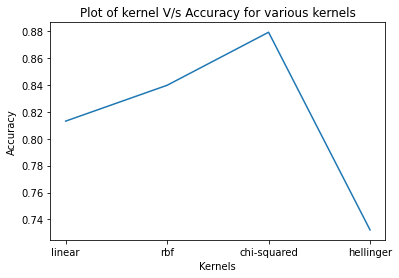

In [49]:
plt.plot(x_axis, y_axis)
plt.xlabel("Kernels")
plt.ylabel("Accuracy")
plt.title("Plot of kernel V/s Accuracy for various kernels")
plt.show()

In [ ]:
# Due to time and resources constraint, were unable to run for this kernel (Intersection Kernel)
model_linear = SVC(kernel=intersection)
model_linear.fit(X_train, y_train)

y_pred = model_linear.predict(X_test)
print("accuracy:", metrics.accuracy_score(y_true=y_test, y_pred=y_pred), "\n")